# END-TO-END REGRESSION: SONG YEAR PREDICTION

**Project Overview:**
This notebook implements a complete machine learning pipeline to predict the release year of songs based on audio features. It includes professional data handling, outlier detection, advanced modeling (Random Forest & XGBoost), and comprehensive evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import warnings
import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("\n✓ All libraries imported successfully!")


✓ All libraries imported successfully!


## 1. Data Loading & Inspection

In [2]:
print(f"\n{'─'*50}")
print("PHASE 1: DATA LOADING")
print(f"{'─'*50}")

output_file = 'midterm-regresi-dataset.csv'
file_id = '1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9'
url = f'https://drive.google.com/uc?id={file_id}'

if not os.path.exists(output_file):
    print(f"• Downloading dataset from Google Drive...")
    gdown.download(url, output_file, quiet=False)
    print("✓ Download complete.")
else:
    print("✓ Dataset already exists locally.")

# Load Data
print("• Reading CSV file...")
df = pd.read_csv(output_file, header=None)

# Rename columns
num_features = df.shape[1] - 1
cols = ['year'] + [f'feature_{i}' for i in range(1, num_features + 1)]
df.columns = cols

print(f"\n──────────────────────────────────────────────────")
print("OUTPUT 1.1: DATASET STATISTICS")
print(f"──────────────────────────────────────────────────")
print(f"• Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"• Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n• First 5 Rows Preview:")
print(df.head().iloc[:, :6].to_string()) # Show only first 6 cols for brevity
print("  ...")


──────────────────────────────────────────────────
PHASE 1: DATA LOADING
──────────────────────────────────────────────────
• Downloading dataset from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=60e58684-6841-4dca-a5a5-dbbea8b4c28c
To: c:\Users\HP Pavilion 15\Documents\ML\UTS\Regresi\midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:40<00:00, 10.9MB/s] 


✓ Download complete.
• Reading CSV file...

──────────────────────────────────────────────────
OUTPUT 1.1: DATASET STATISTICS
──────────────────────────────────────────────────
• Shape: 515,345 rows × 91 columns
• Memory Usage: 357.79 MB

• First 5 Rows Preview:
   year  feature_1  feature_2  feature_3  feature_4  feature_5
0  2001   49.94357   21.47114   73.07750    8.74861  -17.40628
1  2001   48.73215   18.42930   70.32679   12.94636  -10.32437
2  2001   50.95714   31.85602   55.81851   13.41693   -6.57898
3  2001   48.24750   -1.89837   36.29772    2.58776    0.97170
4  2001   50.97020   42.20998   67.09964    8.46791  -15.85279
  ...


## 2. Exploratory Data Analysis (EDA)


──────────────────────────────────────────────────
PHASE 2: TARGET VARIABLE ANALYSIS (Year)
──────────────────────────────────────────────────
count    515345.000000
mean       1998.397082
std          10.931046
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2011.000000
Name: year, dtype: float64

• Year Range: 1922 - 2011
• Most Common Year: 2007


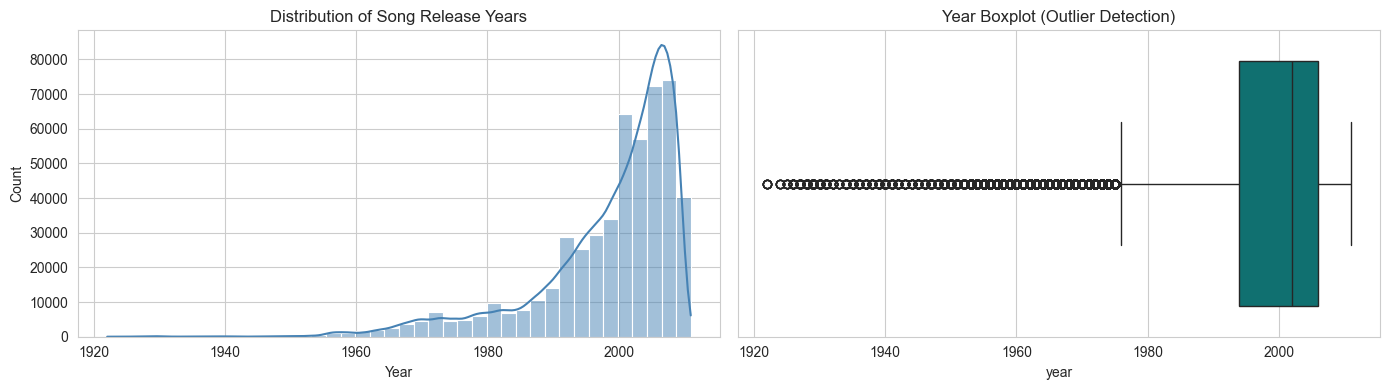

In [3]:
print(f"\n{'─'*50}")
print("PHASE 2: TARGET VARIABLE ANALYSIS (Year)")
print(f"{'─'*50}")

target_stats = df['year'].describe()
print(target_stats)
print(f"\n• Year Range: {int(df['year'].min())} - {int(df['year'].max())}")
print(f"• Most Common Year: {int(df['year'].mode()[0])}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Hist Plot
sns.histplot(df['year'], bins=40, kde=True, color='steelblue', ax=axes[0])
axes[0].set_title('Distribution of Song Release Years', fontsize=12)
axes[0].set_xlabel('Year')

# Box Plot
sns.boxplot(x=df['year'], color='teal', ax=axes[1])
axes[1].set_title('Year Boxplot (Outlier Detection)', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Data Cleaning & Feature Selection

In [4]:
print(f"\n{'─'*50}")
print("PHASE 3: CLEANING & SELECTION")
print(f"{'─'*50}")

# 3.1 Duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows.")
else:
    print("✓ No duplicates found.")

# 3.2 Feature Selection (Correlation)
print("\n• Calculating correlations...")
correlations = df.corr()['year'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > 0.05].index.tolist()
if 'year' in selected_features: selected_features.remove('year')

print(f"• Original Features: 90")
print(f"• Selected Features: {len(selected_features)} (Correlation > 0.05)")
print(f"✓ Top 5 Features: {selected_features[:5]}")

X = df[selected_features]
y = df['year']


──────────────────────────────────────────────────
PHASE 3: CLEANING & SELECTION
──────────────────────────────────────────────────
✓ Removed 214 duplicate rows.

• Calculating correlations...
• Original Features: 90
• Selected Features: 38 (Correlation > 0.05)
✓ Top 5 Features: ['feature_1', 'feature_6', 'feature_3', 'feature_63', 'feature_40']


## 4. Preprocessing & Outlier Handling

In [5]:
print(f"\n{'─'*50}")
print("PHASE 4: PREPROCESSING")
print(f"{'─'*50}")

# 4.1 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"• Training Set: {X_train.shape[0]:,} samples")
print(f"• Test Set: {X_test.shape[0]:,} samples")

# 4.2 Outlier Handling (Clipping 1st and 99th percentile)
# Providing robustness against extreme audio artifacts
print("• Handling outliers (Clipping method)...")
for col in X_train.columns:
    lower = X_train[col].quantile(0.01)
    upper = X_train[col].quantile(0.99)
    X_train[col] = X_train[col].clip(lower, upper)
    X_test[col] = X_test[col].clip(lower, upper)

# 4.3 Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Data scaled (StandardScaler) and outliers clipped.")


──────────────────────────────────────────────────
PHASE 4: PREPROCESSING
──────────────────────────────────────────────────
• Training Set: 412,104 samples
• Test Set: 103,027 samples
• Handling outliers (Clipping method)...
✓ Data scaled (StandardScaler) and outliers clipped.


## 5. Model Training (Advanced Ensembles)

In [6]:
print(f"\n{'─'*50}")
print("PHASE 5: MODEL TRAINING")
print(f"{'─'*50}")

# --- Model 1: Random Forest ---
print("1. Training Random Forest (Baseline)...")
rf_model = RandomForestRegressor(
    n_estimators=50, 
    max_depth=10, 
    n_jobs=-1, 
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("   ✓ Random Forest training complete.")

# --- Model 2: XGBoost (Tuned) ---
print("\n2. Training XGBoost with Hyperparameter Tuning...")
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

random_search = RandomizedSearchCV(
    xgb_reg, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print(f"   ✓ XGBoost training complete.")
print(f"   • Best Params: {random_search.best_params_}")


──────────────────────────────────────────────────
PHASE 5: MODEL TRAINING
──────────────────────────────────────────────────
1. Training Random Forest (Baseline)...
   ✓ Random Forest training complete.

2. Training XGBoost with Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
   ✓ XGBoost training complete.
   • Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


## 6. Evaluation & Visualization


──────────────────────────────────────────────────
PHASE 6: EVALUATION & RESULTS
──────────────────────────────────────────────────

──────────────────────────────────────────────────
EXECUTIVE SUMMARY: MODEL PERFORMANCE
──────────────────────────────────────────────────
          Model     RMSE      MAE       R2
XGBoost (Tuned) 9.220005 6.588496 0.277660
  Random Forest 9.484563 6.776283 0.235612

★ BEST MODEL: XGBoost (Tuned)
  • RMSE: 9.2200
  • R²  : 0.2777


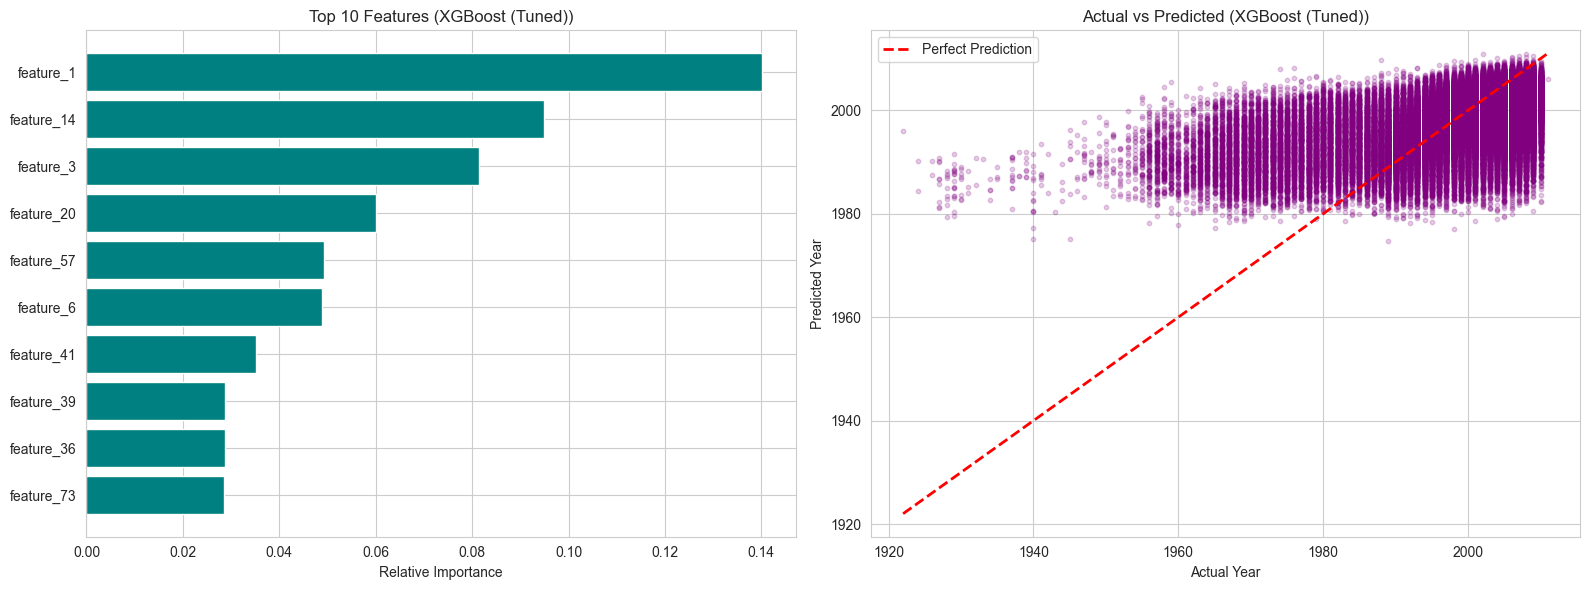

In [7]:
print(f"\n{'─'*50}")
print("PHASE 6: EVALUATION & RESULTS")
print(f"{'─'*50}")

def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

res_rf = print_metrics(y_test, y_pred_rf, "Random Forest")
res_xgb = print_metrics(y_test, y_pred_xgb, "XGBoost (Tuned)")

results_df = pd.DataFrame([res_rf, res_xgb]).sort_values('RMSE')

print("\n──────────────────────────────────────────────────")
print("EXECUTIVE SUMMARY: MODEL PERFORMANCE")
print("──────────────────────────────────────────────────")
print(results_df.to_string(index=False))

# Determine Best Model
best_model_name = results_df.iloc[0]['Model']
best_preds = y_pred_xgb if best_model_name == "XGBoost (Tuned)" else y_pred_rf
best_model_obj = best_xgb if best_model_name == "XGBoost (Tuned)" else rf_model

print(f"\n★ BEST MODEL: {best_model_name}")
print(f"  • RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"  • R²  : {results_df.iloc[0]['R2']:.4f}")

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Feature Importance
importances = best_model_obj.feature_importances_
indices = np.argsort(importances)[::-1][:10]
axes[0].barh(range(len(indices)), importances[indices], align='center', color='teal')
axes[0].set_yticks(range(len(indices)))
axes[0].set_yticklabels([selected_features[i] for i in indices])
axes[0].invert_yaxis()
axes[0].set_xlabel('Relative Importance')
axes[0].set_title(f'Top 10 Features ({best_model_name})', fontsize=12)

# 2. Actual vs Predicted
axes[1].scatter(y_test, best_preds, alpha=0.2, color='purple', s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Year')
axes[1].set_ylabel('Predicted Year')
axes[1].set_title(f'Actual vs Predicted ({best_model_name})', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Prediction Demo

In [8]:
print(f"\n{'─'*50}")
print("PHASE 7: SAMPLE PREDICTIONS")
print(f"{'─'*50}")

# Show 10 random samples from test set
sample_indices = np.random.choice(len(y_test), 10, replace=False)
sample_actual = y_test.iloc[sample_indices].values
sample_pred = best_preds[sample_indices]

print(f"{'Actual':<10} {'Predicted':<10} {'Diff (Years)':<10}")
print("─" * 35)
for act, pred in zip(sample_actual, sample_pred):
    print(f"{int(act):<10} {pred:<10.1f} {act-pred:>5.1f}")


──────────────────────────────────────────────────
PHASE 7: SAMPLE PREDICTIONS
──────────────────────────────────────────────────
Actual     Predicted  Diff (Years)
───────────────────────────────────
2008       2004.4       3.6
1991       1990.6       0.4
2002       1989.9      12.1
2001       2004.4      -3.4
2000       1999.2       0.8
2005       1994.9      10.1
1991       1998.8      -7.8
2007       2004.7       2.3
2003       1988.4      14.6
2002       1989.4      12.6
